In [1]:
import warnings
warnings.filterwarnings("ignore")
import hydroeval as he
import time
import glob
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 600
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.weight'] = "bold"
plt.rcParams['legend.framealpha'] = 0

from datetime import datetime
from pytz import timezone

east = timezone('US/Eastern')

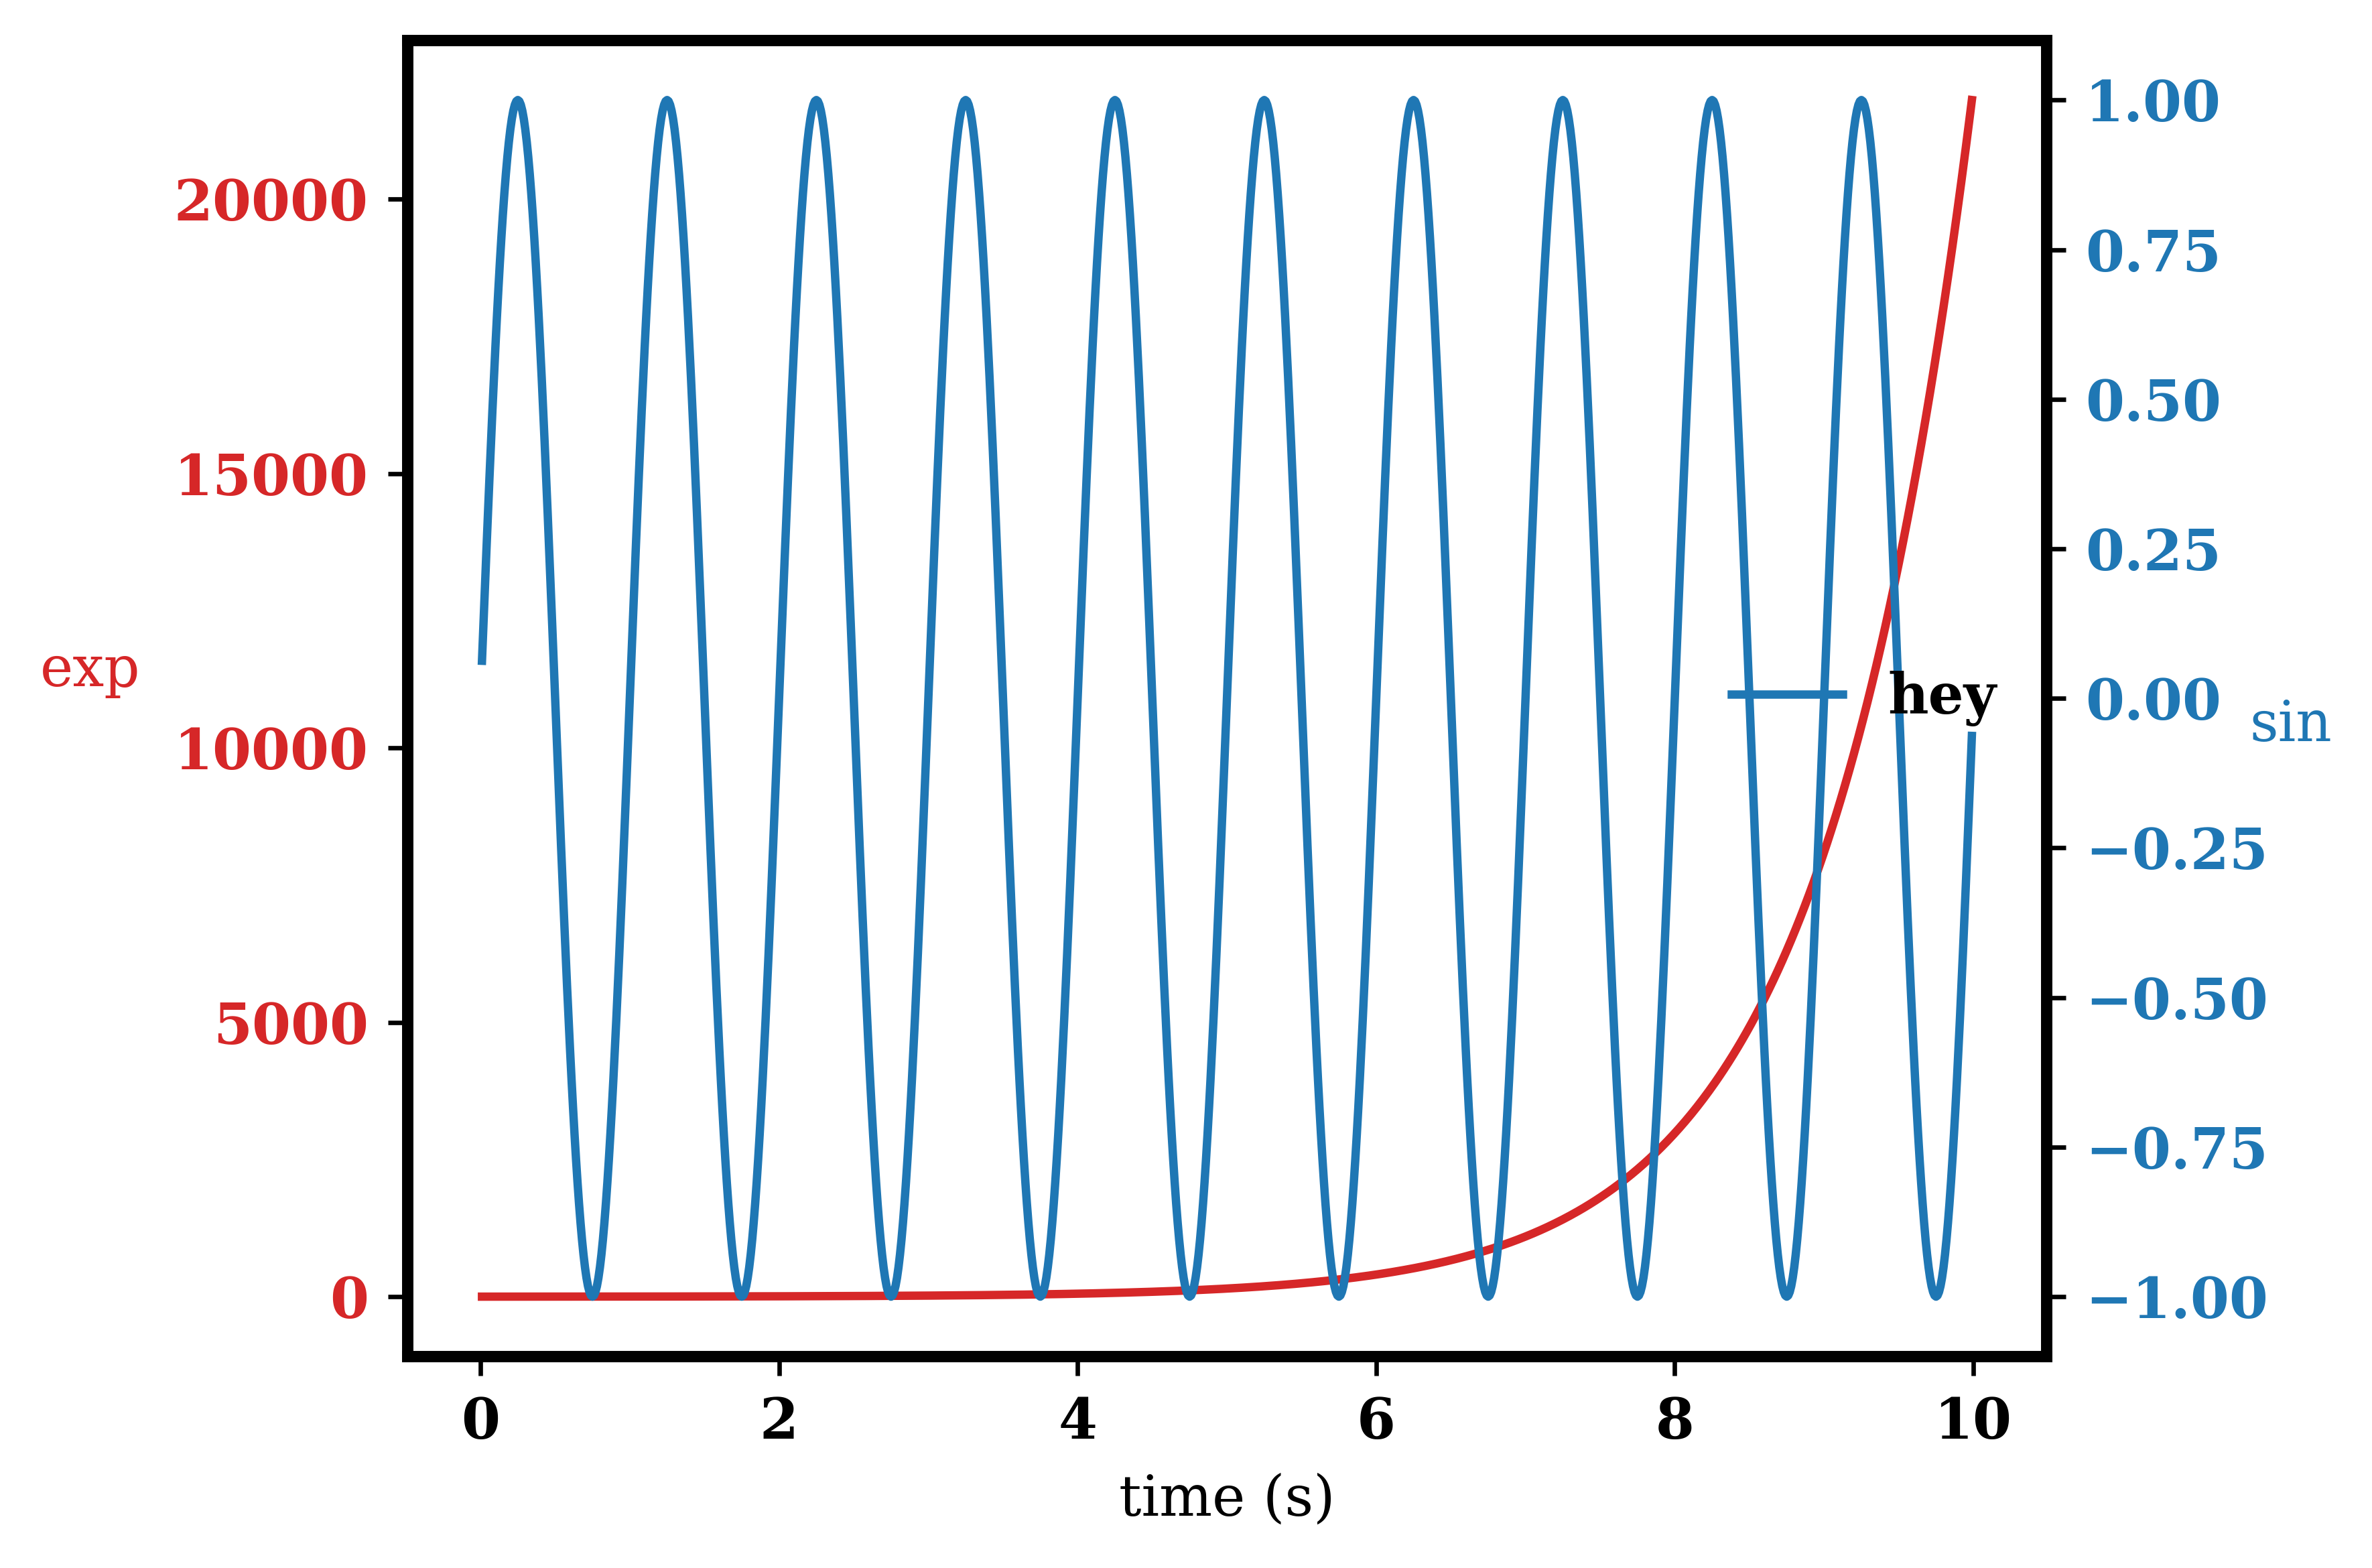

In [2]:



import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = np.arange(0.01, 10.0, 0.01)
data1 = np.exp(t)
data2 = np.sin(2 * np.pi * t)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('exp', color=color,rotation=0,labelpad=15)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('sin', color=color,rotation=0)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend(['hey','hey2'])
plt.show()

In [10]:
basin_idxs = [0,1,2,3]
lags = [0,1,2,4,5,6,7,14]
data_splits = [0.65,0.7,0.75,0.8,.85,0.9,.95]

config = []
idx = 0
for i in basin_idxs:
    for j in lags:
        for k in data_splits:
            config.append((idx,i,j,k))
            idx+=1
len(config)

224

In [17]:
import glob
glob.glob('runs/*/*')

import shutil


In [19]:
shutil.rmtree('runs/')

In [11]:
for idx,x in enumerate(config):
    print(x)
    if idx == 10:
        break

(0, 0, 0, 0.65)
(1, 0, 0, 0.7)
(2, 0, 0, 0.75)
(3, 0, 0, 0.8)
(4, 0, 0, 0.85)
(5, 0, 0, 0.9)
(6, 0, 0, 0.95)
(7, 0, 1, 0.65)
(8, 0, 1, 0.7)
(9, 0, 1, 0.75)
(10, 0, 1, 0.8)


In [14]:
config[5][3]

0.9

In [31]:
def f2f(config_number,basin_idx,lag,data_split):
# basin_idx = 0 ##br = 0, co = 1, ct = 2, ms = 3
# lag = 0
    epochs = 500
    stop = .95 #stop at this training nse
    # data_split = 0.90
    stripchart = (15,5)
    fontsize=20
    # image = (10,10)

    if basin_idx == 3:
        batch_size=1
    else:
        batch_size=2

    def nc2torch(i):
        return torch.from_numpy(np.asarray(i)).unsqueeze(0)

    #gauged flow final handling
    def interp__and__totensor(x):
        x = pd.Series(x).interpolate().tolist()
        return torch.from_numpy(np.asarray(x)).unsqueeze(1).unsqueeze(1).unsqueeze(1)

    if lag == 0:
        times = np.arange(np.datetime64('2015-01-01'),
                          np.datetime64('2022-03-02'), np.timedelta64(1, 'D'))

    ##x-axis becomes time of prediction, with the actual prediction and modeled prediction displayed on the plot.
    else:
        times = np.arange(np.datetime64('2015-01-01'),
                          np.datetime64('2022-03-02') - np.timedelta64(lag, 'D'), np.timedelta64(1, 'D'))

    basin = ['Bear River','Colorado','Connecticut','Mississippi']
    basincode = ['br','co','ct','ms']
    basinvectorsize = [14*13,98*89,30*14,165*286]
    br_co_ct_ms = np.load('br_co_ct_ms.npy')
    br_co_ct_ms_times = np.load('br_co_ct_ms_times.npy')
    br_co_ct_ms = np.where(br_co_ct_ms < -100000,np.nan,br_co_ct_ms)

    for xdx,x in enumerate(br_co_ct_ms):
        if xdx == 0:
            y = interp__and__totensor(x)
        else:
            y = torch.cat((y,interp__and__totensor(x)),axis=1)
    sf = torch.permute(y,[1,0,2,3])

    #plot flows, not necessary but can look @ interpolated and non interpolated.
    # plt.figure(figsize=(stripchart))
    # plt.title('Gauged streamflow')
    # plt.plot(times,br_co_ct_ms[basin_idx])
    # plt.plot(times,sf[basin_idx,:,0,0])
    # plt.legend(['No Interp','Interp'],loc='best')

    #final NLDAS Qs & Qsb handling handling
    imz = torch.load(f'nldas_{basincode[basin_idx]}.pt')
    imz = torch.flip(imz,[2])
    Qs = imz[:,0]
    Qsb = imz[:,1]
    Qz = [Qs, Qsb]

    #plots sample image
    # plt.figure(figsize=(image))
    # plt.title('Sample of Qs basin')
    # plt.imshow(Qs[1000],cmap='cividis')
    # plt.colorbar()
    # plt.gca().set_aspect('equal')

    #zscores Qs

    def zscore(x):
        x = x.numpy()
        x = np.where((x>0) & (x<1000) == True,x,0)
        np_nanmean = np.nanmean(x)
        np_nanstd = np.nanstd(x)
        zscored = (x-np_nanmean)/np_nanstd
        zscored = np.where(np.isfinite(zscored) == False,0,zscored)
        return zscored

    zscoredQs = []
    for y in Qs:
        z = zscore(y)
        zscoredQs.append(z)
    zscoredQs = torch.from_numpy(np.asarray(zscoredQs)).unsqueeze(1)

    #zscores Qsb
    zscoredQsb = []
    for y in Qsb:
        z = zscore(y)
        zscoredQsb.append(z)
    zscoredQsb = torch.from_numpy(np.asarray(zscoredQsb)).unsqueeze(1)
    zscoredQz = torch.cat((zscoredQs,zscoredQsb),axis=1)

    # plt.figure(figsize=image)
    # plt.title('Sample zscored Qs')
    # plt.imshow(zscoredQz[1000,0],cmap='cividis')
    # plt.colorbar(fraction=.025)

    if lag == 0:
        imz__lag = zscoredQz
    else:
        imz__lag = zscoredQz[:-lag]
    streamz__lag = sf[basin_idx,:,0,0][lag:].unsqueeze(1).unsqueeze(1).unsqueeze(1).to(torch.float32)

    print(f"\n\n\nBasin Selected: {basin[basin_idx]}",file=f)

    torch.cuda.empty_cache()
    torch.cuda.current_device()
    # print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            torch.nn.init.normal_(m.weight.data,0.0,0.02)
        elif classname.find('BatchNorm') != -1:
            torch.nn.init.normal_(m.weight.data,1.0,0.02)
            torch.nn.init.constant_(m.bias.data,0)    

    class setter2(Dataset):
        def __init__(self,x,y,z):
            self.x = x[:z]
            self.y = y[:z]
            # self.x = torch.load(x)[:z]
            # self.y = torch.load(y)[:z]
            self.std,self.mean = torch.std_mean(self.y)
            self.y = (self.y - self.mean)/self.std
            self.y = self.y.reshape(self.y.shape[0],self.y.shape[3])
    #         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
    #         self.x = self.x[rand_pts]
    #         self.y = self.y[rand_pts]
        def __getitem__(self,idx):
            x = self.x[idx].to('cuda')
            y = self.y[idx].to('cuda')
            return x, y
        def __len__(self):
            return self.x.shape[0]

    class a(torch.nn.Module):
        def __init__(self):
            super(a,self).__init__()
    #         # in layer
            self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=64, kernel_size=3, padding=1, bias=False)
            self.relu = torch.nn.ReLU(inplace=True)
            # hidden layers
            hidden_layers = []
            for i in range(2):
                hidden_layers.append(torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
                hidden_layers.append(torch.nn.BatchNorm2d(64))
                hidden_layers.append(torch.nn.ReLU(inplace=True))
            self.mid_layer = torch.nn.Sequential(*hidden_layers)
            # out layer
            self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=1, bias=False) #anything below this is for shrinking 
            self.linear1 = torch.nn.Linear(basinvectorsize[basin_idx],100) ### this is what gets changed based on important switch
            self.linear2 = torch.nn.Linear(100,50)
            self.linear3 = torch.nn.Linear(50,20)
            self.linear4 = torch.nn.Linear(20,10)
            self.linear5 = torch.nn.Linear(10,1)
        def forward(self, x):
            out1 = self.relu(self.conv1(x))
            out = self.mid_layer(out1)
            o = self.conv3(out+out1)
            o = self.linear1(o.view(o.size(0),-1))
            o = self.relu(self.linear2(o))
            o = self.relu(self.linear3(o))
            o = self.relu(self.linear4(o))
            o = self.linear5(o)
            return o

    streamz = streamz__lag
    imz = imz__lag

    print(f"\nLag: {lag}",file=f)
    print(f"Stop at: {stop}",file=f)
    print(f"Train / test split %: {tt_split}",file=f)
    print(f"Will run for (epochs): {500}\n",file=f)

    dset = setter2(imz,streamz,streamz__lag.shape[0]) #imz, streamz, shape (could be either streamz__lag or imz__lag shape [0]
    cube_height = dset.x.shape[2]
    cube_width = dset.x.shape[3]

    train_dset_size = int(data_split*len(dset))
    valid_dset_size = int(len(dset) - train_dset_size)
    train_dset, valid_dset = random_split(dset,[train_dset_size,valid_dset_size])

    # train = Subset(dset,range(0,train_dset_size))
    # valid = Subset(dset,range(train_dset_size,train_dset_size+valid_dset_size))

    train_dataloader = DataLoader(dataset=train_dset, batch_size=batch_size, shuffle=False)
    valid_dataloader = DataLoader(dataset=valid_dset, batch_size=batch_size, shuffle=False)

    model = a()
    model.apply(weights_init)
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
    criterion = torch.nn.L1Loss()
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=150,verbose=False)

    print('Training started at {}'.format(datetime.now(east).strftime('%Y-%m-%d %H:%M:%S')),file=f)
    t_loss = []
    v_loss = []
    e_time = []
    nse_during = []
    t0 = time.time()
    for i in range(epochs):
        t_e_loss = 0
        v_e_loss = 0
        train_pred = torch.empty((0,1)).to('cuda')
        train_y = torch.empty((0,1)).to('cuda')
        # val_pred = torch.empty((0,1)).to('cuda')
        # val_y = torch.empty((0,1)).to('cuda')
        t00 = time.time()
        model.train()
        for idx,(x,y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            predicted = model(x)
            train_pred = torch.cat((train_pred,predicted.reshape(-1,1)))
            train_y = torch.cat((train_y,y.reshape(-1,1)))
            loss = criterion(predicted.reshape(-1),y.reshape(-1))
            loss.backward()
            optimizer.step()
            t_e_loss += loss.item()
        for xx,yy in valid_dataloader:
            v_pred = model(xx)
            loss2 = criterion(v_pred.reshape(-1),yy.reshape(-1))
            v_e_loss += loss2.item()
            # val_pred = torch.cat((val_pred,v_pred.reshape(-1,1)))
            # val_y = torch.cat((val_y,yy.reshape(-1,1)))
        nse_epoch_train = he.evaluator(he.nse,train_pred.cpu().detach().numpy(),train_y.cpu().detach().numpy())
        # nse_epoch_valid = he.evaluator(he.nse,val_pred.cpu().detach().numpy(),val_y.cpu().detach().numpy())
        print(f"epoch {i} train:\t {np.around(nse_epoch_train,2)}",file=f)
        nse_during.append(nse_epoch_train)
        t_loss.append(t_e_loss/len(train_dataloader))
        v_loss.append(v_e_loss/len(valid_dataloader))
        t11 = time.time()
        e_time.append(t11-t00)
        if nse_epoch_train > stop:
            break
    t1 = time.time()
    print('Training time {} (minutes)'.format(np.format_float_positional((t1-t0)/60,precision=5)),file=f)




    #inference

    torch.cuda.empty_cache()
    torch.cuda.current_device()
    # print(torch.cuda.device_count())
    # print(torch.cuda.get_device_name(0))

    imageTensor = imz
    streamTensor = streamz

    class setter2infer(Dataset):
        def __init__(self,x,y):
            self.x = x
            self.y = y

            self.std,self.mean = torch.std_mean(self.y)
            self.y = (self.y - self.mean)/self.std

            # print('shape of x',self.x.shape)
            # print('shape of y',self.y.shape)

            # self.x = self.xog.reshape(self.xog.shape[0],self.xog.shape[2]*self.xog.shape[3])
            self.y = self.y.reshape(self.y.shape[0],self.y.shape[3])
    #         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
    #         self.x = self.x[rand_pts]
    #         self.y = self.y[rand_pts]
        def __getitem__(self,idx):
            x = self.x[idx].to('cuda')
    #         x -= torch.min(x)
    #         x /= torch.max(x)
            y = self.y[idx].to('cuda')
    #         y -= torch.min(y)
    #         y /= torch.max(y)
            return x, y
        def __len__(self):
            return self.x.shape[0]


    test_dset = setter2infer(imageTensor,streamTensor)
    # test = Subset(test_dset,range(673,841))
    train_dataloader = DataLoader(dataset=test_dset, batch_size=1, shuffle=False)


    test_predictions = []
    with torch.no_grad():
        for xx,yy in train_dataloader:
            test_pred = model(xx)
            # print(test_pred.shape)
            test_predictions.append(test_pred)

    test_streamflows = [(x*dset.std)+dset.mean for x in test_predictions]
    test_streamflows = torch.Tensor(test_streamflows)
    test_streamflows = test_streamflows.numpy()
    streamz_actual = sf[basin_idx,:,0,0].numpy()



    fontsize=14



    def r_squared(x,y):
        xmean = np.mean(x)
        residuals = np.sum(np.power(x-y,2))
        total = np.sum(np.power(x-xmean,2))
        return 1 - residuals/total

    # def nd(x):
    #     return (x - np.min(x))/(np.max(x) - np.min(x))


    if lag == 0:
        fit = np.polyfit(test_streamflows.reshape(-1),streamz_actual.reshape(-1),1)
        rsq = r_squared(test_streamflows.reshape(-1),streamz_actual.reshape(-1))
    else:
        fit = np.polyfit(test_streamflows.reshape(-1),streamz_actual[lag:].reshape(-1),1)
        rsq = r_squared(test_streamflows.reshape(-1),streamz_actual[lag:].reshape(-1))

    idx = np.linspace(0,np.max(test_streamflows),test_streamflows.shape[0])

    print(f"\nR²\t[{round(rsq,3)}]",file=f)

    fig = plt.figure(figsize=(16,16));
    gs = gridspec.GridSpec(3,1,height_ratios=[.09,.2,.09],hspace=0.3,wspace=0.1) 
    ax2 = fig.add_subplot(gs[0, 0])

    plt.scatter(times,streamz_actual[lag:],color='black',label='Actual',s=.7)
    plt.plot(times,test_streamflows,color='tab:blue',label='Modeled',linewidth=1)
    plt.legend(fontsize=fontsize)
    plt.ylabel('f³s⁻¹',rotation=0, labelpad=25,fontsize=fontsize,fontweight='bold'); 
    plt.xlabel('Year',fontsize=fontsize,fontweight='bold');
    plt.title(f'Hydrographs, {basin[basin_idx]}',fontsize=fontsize,fontweight='bold');
    plt.xticks(fontsize=fontsize); plt.yticks(fontsize=fontsize)


    gs2 = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=gs[1,0],width_ratios=[1,1])
    ax000 = fig.add_subplot(gs2[0,0])
    plt.title('Actual v. Model',fontsize=fontsize,fontweight='bold')
    plt.xlabel('M',fontsize=fontsize,fontweight='bold')
    plt.ylabel('A',fontsize=fontsize,fontweight='bold',rotation=0,labelpad=15)
    plt.plot(test_streamflows,streamz_actual[lag:],'.',color='black',markersize=7)
    plt.plot(idx,idx,'-',color='tab:purple',linewidth=2.5,label='Ideal Line of Best Fit')
    plt.plot(idx,fit[0]*idx+fit[1],color='gold',linewidth=2.5, label= 'Line of Best Fit')
    plt.xticks(fontsize=fontsize); plt.yticks(fontsize=fontsize)
    plt.legend(fontsize=fontsize)

    ax0000 = fig.add_subplot(gs2[0,1])
    plt.hist2d(test_streamflows,streamz_actual[lag:],bins=50,cmap='Greys',vmin=0,vmax=10);
    plt.title('Actual v. Model, 2D Histogram',fontsize=fontsize,fontweight='bold')
    plt.xlabel('M',fontsize=fontsize,fontweight='bold')
    plt.ylabel('A',fontsize=fontsize,fontweight='bold',rotation=0,labelpad=15)
    cbr = plt.colorbar(orientation='vertical',pad=.08)
    cbr.ax.set_title('count',fontsize=fontsize,fontweight='bold')
    cbr.ax.tick_params(labelsize=fontsize)
    plt.xticks(fontsize=fontsize); plt.yticks(fontsize=fontsize)

    plt.gca().set_aspect('auto')

    # if lag == 0:
    #     fit = np.polyfit(nd(test_streamflows).reshape(-1),nd(streamz_actual).reshape(-1),1)
    #     rsq = r_squared(nd(test_streamflows).reshape(-1),nd(streamz_actual).reshape(-1))
    # else:
    #     fit = np.polyfit(nd(test_streamflows).reshape(-1),nd(streamz_actual[lag:]).reshape(-1),1)
    #     rsq = r_squared(nd(test_streamflows).reshape(-1),nd(streamz_actual[lag:]).reshape(-1))

    idx = np.linspace(0,1,test_streamflows.shape[0])

    gs1 = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=gs[2,0],width_ratios=[1,1])
    a00000 = fig.add_subplot(gs1[0,0])
    plt.plot(t_loss,linewidth=2,color='black',linestyle='-',marker="*",markersize=10,markerfacecolor='black',markeredgecolor='black')
    plt.plot(v_loss,linewidth=1,color='black',linestyle='--',marker="o",markersize=10,markerfacecolor='none',markeredgecolor='black')
    plt.legend(['Training Dataset','Validation Dataset'],fontsize=fontsize)
    plt.title('Average Error Per Epoch, Actual v. Model',fontsize=fontsize,fontweight='bold')
    plt.xlabel('Epoch',fontsize=fontsize,fontweight='bold'); 
    plt.xticks(fontsize=fontsize); plt.yticks(fontsize=fontsize)
    # plt.xticks([0,1,2,3,4,5,10,15,20,25,30])

    a11111 = fig.add_subplot(gs1[0,1])
    nse_during = [i*100 for i in nse_during]
    plt.plot(nse_during,linewidth=2,marker='X',linestyle='None',markersize=10,markerfacecolor='black',markeredgecolor='black')
    plt.axhline(y=stop*100, color='black', linestyle=':',label='Neural Net Stop Trigger')
    # plt.plot(np.linspace(0,len(nse_during)-1,len(nse_during)-1),np.tile(stop*100,len(nse_during)-1),color='black',linestyle=':',label='Neural Net Stop Trigger')
    plt.title('Nash Sutcliffe Efficiency, Training Dataset',fontsize=fontsize,fontweight='bold')
    plt.xlabel('Epoch',fontsize=fontsize,fontweight='bold')
    plt.xticks(fontsize=fontsize); plt.yticks(fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.yticks([30,40,50,60,70,80,90,95,100])


    fig.tight_layout()


    kge, r, alpha, beta = he.evaluator(he.kge,test_streamflows,streamz_actual[lag:])
    print(f'KGE\t{np.round(kge,3)}\nr\t{np.round(r,3)}\nα\t{np.round(alpha,3)}\nβ\t{np.round(beta,3)}',file=f)

    nse = he.evaluator(he.nse,test_streamflows,streamz_actual[lag:])
    print(f'NSE\t{100*np.round(nse,3)}',file=f)

    plt.savefig(f'fig{config_number}.png',bbox_inches='tight',file=f)
    return _

IndentationError: expected an indented block (3119279657.py, line 3)

In [5]:
torch.save(model,'br_nse96.pt')
# saving good run of bear river.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import time
import glob
# import xarray as xr
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import hydroeval as he


plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams['font.size'] = 10
plt.rcParams['figure.dpi'] = 300
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.weight'] = "bold"
plt.rcParams['legend.framealpha'] = 0

from datetime import datetime
from pytz import timezone

east = timezone('US/Eastern')

def f2f(config_number,basin_idx,lag,data_split):
# basin_idx = 0 ##br = 0, co = 1, ct = 2, ms = 3
# lag = 0
    epochs = 500
    stop = .95 #stop at this training nse
    # data_split = 0.90
    stripchart = (15,5)
    fontsize=20
    # image = (10,10)

    if basin_idx == 3:
        batch_size=1
    else:
        batch_size=2

    def nc2torch(i):
        return torch.from_numpy(np.asarray(i)).unsqueeze(0)

    #gauged flow final handling
    def interp__and__totensor(x):
        x = pd.Series(x).interpolate().tolist()
        return torch.from_numpy(np.asarray(x)).unsqueeze(1).unsqueeze(1).unsqueeze(1)

    if lag == 0:
        times = np.arange(np.datetime64('2015-01-01'),
                          np.datetime64('2022-03-02'), np.timedelta64(1, 'D'))

    ##x-axis becomes time of prediction, with the actual prediction and modeled prediction displayed on the plot.
    else:
        times = np.arange(np.datetime64('2015-01-01'),
                          np.datetime64('2022-03-02') - np.timedelta64(lag, 'D'), np.timedelta64(1, 'D'))

    basin = ['Bear River','Colorado','Connecticut','Mississippi']
    basincode = ['br','co','ct','ms']
    basinvectorsize = [14*13,98*89,30*14,165*286]
    br_co_ct_ms = np.load('br_co_ct_ms.npy')
    br_co_ct_ms_times = np.load('br_co_ct_ms_times.npy')
    br_co_ct_ms = np.where(br_co_ct_ms < -100000,np.nan,br_co_ct_ms)

    for xdx,x in enumerate(br_co_ct_ms):
        if xdx == 0:
            y = interp__and__totensor(x)
        else:
            y = torch.cat((y,interp__and__totensor(x)),axis=1)
    sf = torch.permute(y,[1,0,2,3])

    #plot flows, not necessary but can look @ interpolated and non interpolated.
    # plt.figure(figsize=(stripchart))
    # plt.title('Gauged streamflow')
    # plt.plot(times,br_co_ct_ms[basin_idx])
    # plt.plot(times,sf[basin_idx,:,0,0])
    # plt.legend(['No Interp','Interp'],loc='best')

    #final NLDAS Qs & Qsb handling handling
    imz = torch.load(f'nldas_{basincode[basin_idx]}.pt')
    imz = torch.flip(imz,[2])
    Qs = imz[:,0]
    Qsb = imz[:,1]
    Qz = [Qs, Qsb]

    #plots sample image
    # plt.figure(figsize=(image))
    # plt.title('Sample of Qs basin')
    # plt.imshow(Qs[1000],cmap='cividis')
    # plt.colorbar()
    # plt.gca().set_aspect('equal')

    #zscores Qs

    def zscore(x):
        x = x.numpy()
        x = np.where((x>0) & (x<1000) == True,x,0)
        np_nanmean = np.nanmean(x)
        np_nanstd = np.nanstd(x)
        zscored = (x-np_nanmean)/np_nanstd
        zscored = np.where(np.isfinite(zscored) == False,0,zscored)
        return zscored

    zscoredQs = []
    for y in Qs:
        z = zscore(y)
        zscoredQs.append(z)
    zscoredQs = torch.from_numpy(np.asarray(zscoredQs)).unsqueeze(1)

    #zscores Qsb
    zscoredQsb = []
    for y in Qsb:
        z = zscore(y)
        zscoredQsb.append(z)
    zscoredQsb = torch.from_numpy(np.asarray(zscoredQsb)).unsqueeze(1)
    zscoredQz = torch.cat((zscoredQs,zscoredQsb),axis=1)

    # plt.figure(figsize=image)
    # plt.title('Sample zscored Qs')
    # plt.imshow(zscoredQz[1000,0],cmap='cividis')
    # plt.colorbar(fraction=.025)

    if lag == 0:
        imz__lag = zscoredQz
    else:
        imz__lag = zscoredQz[:-lag]
    streamz__lag = sf[basin_idx,:,0,0][lag:].unsqueeze(1).unsqueeze(1).unsqueeze(1).to(torch.float32)

    print(f"\n\n\nBasin Selected: {basin[basin_idx]}",file=f)

    torch.cuda.empty_cache()
    torch.cuda.current_device()
    # print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0),file=f)

    def weights_init(m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            torch.nn.init.normal_(m.weight.data,0.0,0.02)
        elif classname.find('BatchNorm') != -1:
            torch.nn.init.normal_(m.weight.data,1.0,0.02)
            torch.nn.init.constant_(m.bias.data,0)    

    class setter2(Dataset):
        def __init__(self,x,y,z):
            self.x = x[:z]
            self.y = y[:z]
            # self.x = torch.load(x)[:z]
            # self.y = torch.load(y)[:z]
            self.std,self.mean = torch.std_mean(self.y)
            self.y = (self.y - self.mean)/self.std
            self.y = self.y.reshape(self.y.shape[0],self.y.shape[3])
    #         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
    #         self.x = self.x[rand_pts]
    #         self.y = self.y[rand_pts]
        def __getitem__(self,idx):
            x = self.x[idx].to('cuda')
            y = self.y[idx].to('cuda')
            return x, y
        def __len__(self):
            return self.x.shape[0]

    class a(torch.nn.Module):
        def __init__(self):
            super(a,self).__init__()
    #         # in layer
            self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=64, kernel_size=3, padding=1, bias=False)
            self.relu = torch.nn.ReLU(inplace=True)
            # hidden layers
            hidden_layers = []
            for i in range(2):
                hidden_layers.append(torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, bias=False))
                hidden_layers.append(torch.nn.BatchNorm2d(64))
                hidden_layers.append(torch.nn.ReLU(inplace=True))
            self.mid_layer = torch.nn.Sequential(*hidden_layers)
            # out layer
            self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=1, bias=False) #anything below this is for shrinking 
            self.linear1 = torch.nn.Linear(basinvectorsize[basin_idx],100) ### this is what gets changed based on important switch
            self.linear2 = torch.nn.Linear(100,50)
            self.linear3 = torch.nn.Linear(50,20)
            self.linear4 = torch.nn.Linear(20,10)
            self.linear5 = torch.nn.Linear(10,1)
        def forward(self, x):
            out1 = self.relu(self.conv1(x))
            out = self.mid_layer(out1)
            o = self.conv3(out+out1)
            o = self.linear1(o.view(o.size(0),-1))
            o = self.relu(self.linear2(o))
            o = self.relu(self.linear3(o))
            o = self.relu(self.linear4(o))
            o = self.linear5(o)
            return o

    streamz = streamz__lag
    imz = imz__lag

    print(f"\nLag: {lag}",file=f)
    print(f"Stop at: {stop}",file=f)
    print(f"Train / test split %: {data_split}",file=f)
    print(f"Will run for (epochs): {500}\n",file=f)

    dset = setter2(imz,streamz,streamz__lag.shape[0]) #imz, streamz, shape (could be either streamz__lag or imz__lag shape [0]
    cube_height = dset.x.shape[2]
    cube_width = dset.x.shape[3]

    train_dset_size = int(data_split*len(dset))
    valid_dset_size = int(len(dset) - train_dset_size)
    train_dset, valid_dset = random_split(dset,[train_dset_size,valid_dset_size])

    # train = Subset(dset,range(0,train_dset_size))
    # valid = Subset(dset,range(train_dset_size,train_dset_size+valid_dset_size))

    train_dataloader = DataLoader(dataset=train_dset, batch_size=batch_size, shuffle=False)
    valid_dataloader = DataLoader(dataset=valid_dset, batch_size=batch_size, shuffle=False)

    model = a()
    model.apply(weights_init)
    model.cuda()
    optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)
    criterion = torch.nn.L1Loss()
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,step_size=150,verbose=False)

    print('Training started at {}'.format(datetime.now(east).strftime('%Y-%m-%d %H:%M:%S')),file=f)
    t_loss = []
    v_loss = []
    e_time = []
    nse_during = []
    t0 = time.time()
    for i in range(epochs):
        t_e_loss = 0
        v_e_loss = 0
        train_pred = torch.empty((0,1)).to('cuda')
        train_y = torch.empty((0,1)).to('cuda')
        # val_pred = torch.empty((0,1)).to('cuda')
        # val_y = torch.empty((0,1)).to('cuda')
        t00 = time.time()
        model.train()
        for idx,(x,y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            predicted = model(x)
            train_pred = torch.cat((train_pred,predicted.reshape(-1,1)))
            train_y = torch.cat((train_y,y.reshape(-1,1)))
            loss = criterion(predicted.reshape(-1),y.reshape(-1))
            loss.backward()
            optimizer.step()
            t_e_loss += loss.item()
        for xx,yy in valid_dataloader:
            v_pred = model(xx)
            loss2 = criterion(v_pred.reshape(-1),yy.reshape(-1))
            v_e_loss += loss2.item()
            # val_pred = torch.cat((val_pred,v_pred.reshape(-1,1)))
            # val_y = torch.cat((val_y,yy.reshape(-1,1)))
        nse_epoch_train = he.evaluator(he.nse,train_pred.cpu().detach().numpy(),train_y.cpu().detach().numpy())
        # nse_epoch_valid = he.evaluator(he.nse,val_pred.cpu().detach().numpy(),val_y.cpu().detach().numpy())
        print(f"epoch {i} train:\t {np.around(nse_epoch_train,2)}",file=f)
        nse_during.append(nse_epoch_train)
        t_loss.append(t_e_loss/len(train_dataloader))
        v_loss.append(v_e_loss/len(valid_dataloader))
        t11 = time.time()
        e_time.append(t11-t00)
        if nse_epoch_train > stop:
            break
    t1 = time.time()
    print('Training time {} (minutes)'.format(np.format_float_positional((t1-t0)/60,precision=5)),file=f)




    #inference

    torch.cuda.empty_cache()
    torch.cuda.current_device()
    # print(torch.cuda.device_count())
    # print(torch.cuda.get_device_name(0))

    imageTensor = imz
    streamTensor = streamz

    class setter2infer(Dataset):
        def __init__(self,x,y):
            self.x = x
            self.y = y

            self.std,self.mean = torch.std_mean(self.y)
            self.y = (self.y - self.mean)/self.std

            # print('shape of x',self.x.shape)
            # print('shape of y',self.y.shape)

            # self.x = self.xog.reshape(self.xog.shape[0],self.xog.shape[2]*self.xog.shape[3])
            self.y = self.y.reshape(self.y.shape[0],self.y.shape[3])
    #         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],1000))
    #         self.x = self.x[rand_pts]
    #         self.y = self.y[rand_pts]
        def __getitem__(self,idx):
            x = self.x[idx].to('cuda')
    #         x -= torch.min(x)
    #         x /= torch.max(x)
            y = self.y[idx].to('cuda')
    #         y -= torch.min(y)
    #         y /= torch.max(y)
            return x, y
        def __len__(self):
            return self.x.shape[0]


    test_dset = setter2infer(imageTensor,streamTensor)
    # test = Subset(test_dset,range(673,841))
    train_dataloader = DataLoader(dataset=test_dset, batch_size=1, shuffle=False)


    test_predictions = []
    with torch.no_grad():
        for xx,yy in train_dataloader:
            test_pred = model(xx)
            # print(test_pred.shape)
            test_predictions.append(test_pred)

    test_streamflows = [(x*dset.std)+dset.mean for x in test_predictions]
    test_streamflows = torch.Tensor(test_streamflows)
    test_streamflows = test_streamflows.numpy()
    streamz_actual = sf[basin_idx,:,0,0].numpy()



    fontsize=14



    def r_squared(x,y):
        xmean = np.mean(x)
        residuals = np.sum(np.power(x-y,2))
        total = np.sum(np.power(x-xmean,2))
        return 1 - residuals/total

    # def nd(x):
    #     return (x - np.min(x))/(np.max(x) - np.min(x))


    if lag == 0:
        fit = np.polyfit(test_streamflows.reshape(-1),streamz_actual.reshape(-1),1)
        rsq = r_squared(test_streamflows.reshape(-1),streamz_actual.reshape(-1))
    else:
        fit = np.polyfit(test_streamflows.reshape(-1),streamz_actual[lag:].reshape(-1),1)
        rsq = r_squared(test_streamflows.reshape(-1),streamz_actual[lag:].reshape(-1))

    idx = np.linspace(0,np.max(test_streamflows),test_streamflows.shape[0])

    print(f"\nR²\t[{round(rsq,3)}]",file=f)

    fig = plt.figure(figsize=(16,16));
    gs = gridspec.GridSpec(3,1,height_ratios=[.09,.2,.09],hspace=0.3,wspace=0.1) 
    ax2 = fig.add_subplot(gs[0, 0])

    plt.scatter(times,streamz_actual[lag:],color='black',label='Actual',s=.7)
    plt.plot(times,test_streamflows,color='tab:blue',label='Modeled',linewidth=1)
    plt.legend(fontsize=fontsize)
    plt.ylabel('f³s⁻¹',rotation=0, labelpad=25,fontsize=fontsize,fontweight='bold'); 
    plt.xlabel('Year',fontsize=fontsize,fontweight='bold');
    plt.title(f'Hydrographs, {basin[basin_idx]}',fontsize=fontsize,fontweight='bold');
    plt.xticks(fontsize=fontsize); plt.yticks(fontsize=fontsize)


    gs2 = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=gs[1,0],width_ratios=[1,1])
    ax000 = fig.add_subplot(gs2[0,0])
    plt.title('Actual v. Model',fontsize=fontsize,fontweight='bold')
    plt.xlabel('M',fontsize=fontsize,fontweight='bold')
    plt.ylabel('A',fontsize=fontsize,fontweight='bold',rotation=0,labelpad=15)
    plt.plot(test_streamflows,streamz_actual[lag:],'.',color='black',markersize=7)
    plt.plot(idx,idx,'-',color='tab:purple',linewidth=2.5,label='Ideal Line of Best Fit')
    plt.plot(idx,fit[0]*idx+fit[1],color='gold',linewidth=2.5, label= 'Line of Best Fit')
    plt.xticks(fontsize=fontsize); plt.yticks(fontsize=fontsize)
    plt.legend(fontsize=fontsize)

    ax0000 = fig.add_subplot(gs2[0,1])
    plt.hist2d(test_streamflows,streamz_actual[lag:],bins=50,cmap='Greys',vmin=0,vmax=10);
    plt.title('Actual v. Model, 2D Histogram',fontsize=fontsize,fontweight='bold')
    plt.xlabel('M',fontsize=fontsize,fontweight='bold')
    plt.ylabel('A',fontsize=fontsize,fontweight='bold',rotation=0,labelpad=15)
    cbr = plt.colorbar(orientation='vertical',pad=.08)
    cbr.ax.set_title('count',fontsize=fontsize,fontweight='bold')
    cbr.ax.tick_params(labelsize=fontsize)
    plt.xticks(fontsize=fontsize); plt.yticks(fontsize=fontsize)

    plt.gca().set_aspect('auto')

    # if lag == 0:
    #     fit = np.polyfit(nd(test_streamflows).reshape(-1),nd(streamz_actual).reshape(-1),1)
    #     rsq = r_squared(nd(test_streamflows).reshape(-1),nd(streamz_actual).reshape(-1))
    # else:
    #     fit = np.polyfit(nd(test_streamflows).reshape(-1),nd(streamz_actual[lag:]).reshape(-1),1)
    #     rsq = r_squared(nd(test_streamflows).reshape(-1),nd(streamz_actual[lag:]).reshape(-1))

    idx = np.linspace(0,1,test_streamflows.shape[0])

    gs1 = gridspec.GridSpecFromSubplotSpec(1,2,subplot_spec=gs[2,0],width_ratios=[1,1])
    a00000 = fig.add_subplot(gs1[0,0])
    plt.plot(t_loss,linewidth=2,color='black',linestyle='-',marker="*",markersize=10,markerfacecolor='black',markeredgecolor='black')
    plt.plot(v_loss,linewidth=1,color='black',linestyle='--',marker="o",markersize=10,markerfacecolor='none',markeredgecolor='black')
    plt.legend(['Training Dataset','Validation Dataset'],fontsize=fontsize)
    plt.title('Average Error Per Epoch, Actual v. Model',fontsize=fontsize,fontweight='bold')
    plt.xlabel('Epoch',fontsize=fontsize,fontweight='bold'); 
    plt.xticks(fontsize=fontsize); plt.yticks(fontsize=fontsize)
    # plt.xticks([0,1,2,3,4,5,10,15,20,25,30])

    a11111 = fig.add_subplot(gs1[0,1])
    nse_during = [i*100 for i in nse_during]
    plt.plot(nse_during,linewidth=2,marker='X',linestyle='None',markersize=10,markerfacecolor='black',markeredgecolor='black')
    plt.axhline(y=stop*100, color='black', linestyle=':',label='Neural Net Stop Trigger')
    # plt.plot(np.linspace(0,len(nse_during)-1,len(nse_during)-1),np.tile(stop*100,len(nse_during)-1),color='black',linestyle=':',label='Neural Net Stop Trigger')
    plt.title('Nash Sutcliffe Efficiency, Training Dataset',fontsize=fontsize,fontweight='bold')
    plt.xlabel('Epoch',fontsize=fontsize,fontweight='bold')
    plt.xticks(fontsize=fontsize); plt.yticks(fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.yticks([30,40,50,60,70,80,90,95,100])


    fig.tight_layout()


    kge, r, alpha, beta = he.evaluator(he.kge,test_streamflows,streamz_actual[lag:])
    print(f'KGE\t{np.round(kge,3)}\nr\t{np.round(r,3)}\nα\t{np.round(alpha,3)}\nβ\t{np.round(beta,3)}',file=f)

    nse = he.evaluator(he.nse,test_streamflows,streamz_actual[lag:])
    print(f'NSE\t{100*np.round(nse,3)}',file=f)

    plt.savefig(f'imz/fig_{basin_idx}_{str(lag).zfill(2)}_{str(data_split*100).zfill(2)}_{str(config_number).zfill(3)}.png',bbox_inches='tight',file=f)
    plt.close()
    return rsq,kge,nse



basin_idxs = [0,1,2,3]
lags = [0,1,2,3,4,5,6,7,14]
data_split = [0.65,0.7,0.75,0.8,.85,0.9,.95]


config = []
idx = 0
for i in basin_idxs:
    for j in lags:
        for k in data_split:
            config.append((idx,i,j,k))
            idx+=1

macroscale_results = []
for idx,x in enumerate(config):
    if (idx+1) % 2 == 0:
        print(idx)
    with open(f'numz/{str(idx).zfill(3)}.txt', 'w') as f:
        rsq,kge,nse = f2f(x[0],x[1],x[2],x[3])
        macroscale_results.append((idx,rsq,kge,nse))
        f.close()
    
macroscale_results = np.asarray(macroscale_results)
np.save('/work/albertl_uri_edu/fluxtoflow/files_for_paper/configured/macroscale_results.npy',macroscale_results,allow_pickle=False)

In [24]:
pwd

'/work/albertl_uri_edu/fluxtoflow/files_for_paper'